<a href="https://colab.research.google.com/github/amthreeh/-dacon-papering/blob/main/%5Bfl_score_0_51536%5Dljw_v1_0506.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

#이미지 확인
import torchvision
import matplotlib.pyplot as plt
import PIL

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
import zipfile
import os

In [4]:
pwd

'/content'

In [5]:
cd /content/drive/MyDrive/papering

/content/drive/MyDrive/papering


# unzip

In [6]:
!unzip open.zip -d ./data

Archive:  open.zip
replace ./data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Hyperparameter setting

In [7]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

# fixed randomseed

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# 데이터 전처리

In [9]:
all_img_list = glob.glob('./data/train/*/*')

In [10]:
print(all_img_list)

['./data/train/반점/2.png', './data/train/반점/0.png', './data/train/반점/1.png', './data/train/이음부불량/0.png', './data/train/이음부불량/5.png', './data/train/이음부불량/10.png', './data/train/이음부불량/4.png', './data/train/이음부불량/11.png', './data/train/이음부불량/14.png', './data/train/이음부불량/13.png', './data/train/이음부불량/3.png', './data/train/이음부불량/1.png', './data/train/이음부불량/6.png', './data/train/이음부불량/8.png', './data/train/이음부불량/16.png', './data/train/이음부불량/12.png', './data/train/이음부불량/2.png', './data/train/이음부불량/15.png', './data/train/이음부불량/7.png', './data/train/이음부불량/9.png', './data/train/걸레받이수정/0.png', './data/train/걸레받이수정/99.png', './data/train/걸레받이수정/89.png', './data/train/걸레받이수정/171.png', './data/train/걸레받이수정/154.png', './data/train/걸레받이수정/104.png', './data/train/걸레받이수정/175.png', './data/train/걸

In [11]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[3])

In [12]:
df.head()

,img_path,label
0,./data/train/반점/2.png,반점
1,./data/train/반점/0.png,반점
2,./data/train/반점/1.png,반점
3,./data/train/이음부불량/0.png,이음부불량
4,./data/train/이음부불량/5.png,이음부불량


In [13]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.3, stratify=df['label'], random_state=CFG['SEED'])

# label encoding

In [14]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [15]:
le.fit_transform(train['label'])

array([18, 18, 18, ...,  6, 18,  7])

# Custom_dataset

In [16]:
class CustomDataset(Dataset):
  def __init__(self, img_path_list, label_list, transforms=None):
    self.img_path_list = img_path_list
    self.label_list = label_list
    self.transforms = transforms

  def __getitem__(self, index):
    img_path = self.img_path_list[index]
    
    image = cv2.imread(img_path)

    if self.transforms is not None:
      image = self.transforms(image=image)['image']

    if self.label_list is not None:
      label = self.label_list[index]
      return image, label
    else:
      return image

  def __len__(self):
    return len(self.img_path_list)

# augmentation

In [17]:
train_transform = A.Compose([
    A.Resize(224,224), # 이미지 리사이즈
    A.Transpose(p=0.5), # 이미지 반전
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])


In [18]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [19]:
cv2.imread(train_dataset.img_path_list[0])

array([[[133, 135, 143],
        [134, 136, 144],
        [134, 136, 144],
        ...,
        [160, 164, 175],
        [163, 167, 178],
        [170, 174, 185]],

       [[135, 137, 145],
        [134, 136, 144],
        [135, 137, 145],
        ...,
        [151, 156, 167],
        [152, 157, 168],
        [164, 169, 180]],

       [[137, 139, 147],
        [135, 137, 145],
        [136, 138, 146],
        ...,
        [152, 158, 169],
        [157, 163, 174],
        [171, 177, 188]],

       ...,

       [[ 56,  49,  52],
        [ 51,  44,  47],
        [ 49,  40,  43],
        ...,
        [123, 136, 158],
        [123, 137, 159],
        [123, 137, 159]],

       [[ 55,  48,  51],
        [ 48,  41,  44],
        [ 47,  36,  39],
        ...,
        [124, 137, 159],
        [121, 135, 157],
        [121, 135, 158]],

       [[ 53,  46,  49],
        [ 48,  41,  44],
        [ 47,  37,  40],
        ...,
        [122, 136, 159],
        [123, 136, 160],
        [120, 134, 160]]

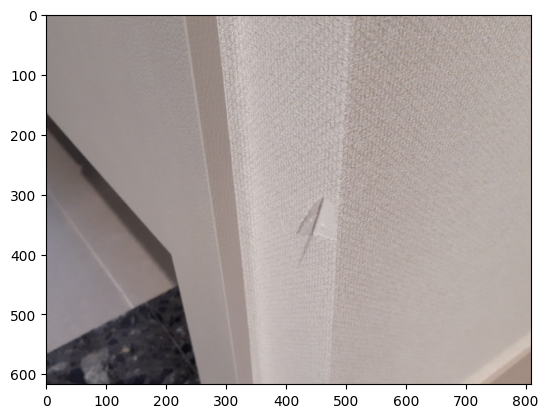

In [20]:
raw_image = plt.imread(train_dataset.img_path_list[0])
plt.imshow(raw_image)

In [21]:
def converter(augmentationed_image):
  mean=(0.485, 0.456, 0.406)
  std=(0.229, 0.224, 0.225)
  
  ### 역함수 로직을 짜주세요. ###
  augmentationed_image = augmentationed_image.permute(1,2,0) # 채널축 정상적으로 맨뒤로 보내기
  augmentationed_image = augmentationed_image.numpy() # numpy 타입으로 변환
  augmentationed_image = (augmentationed_image * std) + mean # unnormalize
  converted_image = augmentationed_image * 255
  converted_image = converted_image.astype(int)

  return converted_image

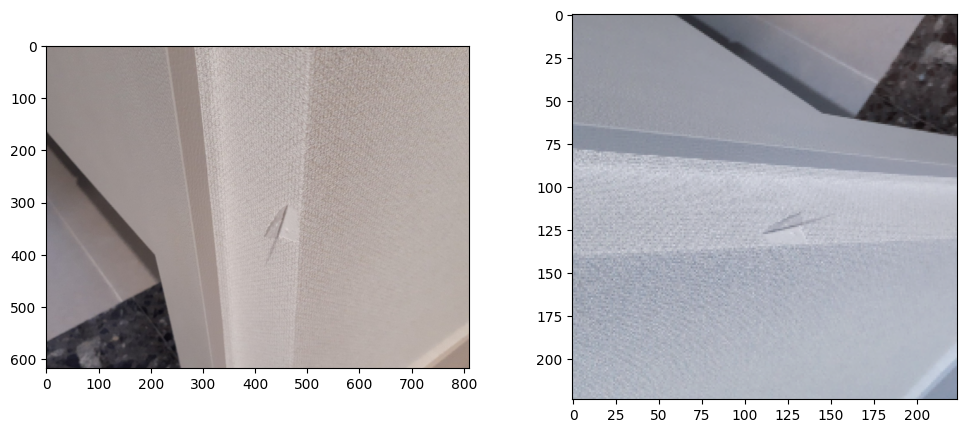

In [22]:
converted_image = converter(train_dataset[0][0])

plt.figure(figsize = (12,5))

plt.subplot(1, 2, 1) 
raw_image = plt.imread(train_dataset.img_path_list[0])
plt.imshow(raw_image)

plt.subplot(1, 2, 2) 
plt.imshow(converted_image)

# model define

In [23]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [24]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [25]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

In [26]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 47.6MB/s]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.64585] Val Loss : [1.10130] Val Weighted F1 Score : [0.62325]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.02897] Val Loss : [0.87003] Val Weighted F1 Score : [0.70808]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.78510] Val Loss : [0.82910] Val Weighted F1 Score : [0.71928]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.67679] Val Loss : [0.81345] Val Weighted F1 Score : [0.73397]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.53303] Val Loss : [0.79523] Val Weighted F1 Score : [0.76244]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.42329] Val Loss : [0.85886] Val Weighted F1 Score : [0.75029]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.37981] Val Loss : [0.87201] Val Weighted F1 Score : [0.76131]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.36059] Val Loss : [0.86727] Val Weighted F1 Score : [0.77797]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.30742] Val Loss : [0.96734] Val Weighted F1 Score : [0.75922]


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.26144] Val Loss : [0.93829] Val Weighted F1 Score : [0.78223]


In [37]:
pwd

'/content/drive/MyDrive/papering'

In [39]:
test = pd.read_csv('./data/test.csv')

In [40]:
test.head()

,id,img_path
0,TEST_000,./test/000.png
1,TEST_001,./test/001.png
2,TEST_002,./test/002.png
3,TEST_003,./test/003.png
4,TEST_004,./test/004.png


In [30]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [41]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [42]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
submit = pd.read_csv('./data/sample_submission.csv')

In [45]:
submit['label'] = preds

In [56]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [57]:
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,몰딩수정
4,TEST_004,훼손


In [58]:
submit.to_csv('./baseline_submit.csv', index=False)